<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Capstone Project:
### FeelFlow AI: Decoding Emotions, Advancing Patient Support

---

### **Background**

In Singapore, the urgency to address mental health issues among younger generations, particularly GenZ and millennials, is critical due to increasing pressures from work, school, and personal relationships leading to anxiety, depression, and substance abuse. Recognizing this, the Ministry of Health and AI Singapore (NUS) have initiated the "Mental Health with AI" Seminar to integrate AI technologies with clinical practices, enhancing therapeutic processes.

The aims of this study is to develop a real-time emotion predictor app. The objective is to alleviate the layer of assessing patients' emotional well-being, which is crucial in enabling a more accurate diagnosis and treatment from. The app is in its beta stages, but seeks to be presented at the seminar for. Further discussions to adoption and integration into pre-existing app/softwares can be opened during this seminar. 

### **Problem Statement**
##### *Where discerning people’s emotion can sometimes be an unnerving guessing game. How can clinicians use speech emotion recognition technology to accurately assess patients' emotional well-being, thereby improving diagnosis and treatment outcomes?*

### **Table of Contents**

### 4. [Modeling (Seen)](#modeling-seen)
   #### 4.1 [Model Preparation](#model-preparation)
   ##### 4.1.1 [Random Seed](#random-seed)
   ##### 4.1.2 [Loading the Dataset](#loading-the-dataset)
   ##### 4.1.3 [Defining the 'X' and 'y'](#defining-x-and-y)
   ##### 4.1.4 [Scaling Features (using `StandardScaler`)](#scaling-features)
   ##### 4.1.5 [Encoding labels (using `LabelEncoder`)](#encoding-labels)
   ##### 4.1.6 [Class Weights](#class-weights)
   #### 4.2 [Model Execution](#model-execution)
   ##### 4.2.1 [Random Forest Classifier](#random-forest-classifier)
   ##### 4.2.2 [MLP Classifier](#mlp-classifier)
   ##### 4.2.3 [LSTM + 1D CNN](#lstm-1d-cnn)
   ##### 4.2.4 [LSTM + 2D CNN](#lstm-2d-cnn)
   ##### 4.2.5 [WaveNet](#wavenet)
   #### 4.3 [Model Evaluation](#model-evaluation)


## **4. Modeling (Seen)**<a id='modeling-seen'></a>

##### *Note: It is advisable to run this notebook on Python 3.8.19 or earlier.*

### Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import time

# Audio-Specific
import librosa

# Visualusations
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display

# Models
import pickle
import random
from scipy.stats import describe
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

##Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, Bidirectional, Input, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# setting displays
%matplotlib inline
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### **4.1 Model Preparation**<a id='model-preparation'></a>

For the modeling preparation, we will following this sequence, since it applies to most models. The MLP Classifier model is the only exception that will proceed with its own scaling and model architecture after the `Defining the 'X' and 'y'` stage.

* Setting of Random Seed
* Loading of Dataset
* Defining the 'X' and 'y'
* Scaling Features
* Adding Class Weights

#### **4.1.1 Random Seed**<a id='random-seed'></a>

Here we set the random seed, for the standardisation and reproducibility of results even after multiple runs. We will put this in every modeling cell.

In [2]:
# Setting random seed for Neural Network models to reproduce standard results with each run
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

#### **4.1.2 Loading the Dataset**<a id='loading-the-dataset'></a>

In [3]:
data = pd.read_csv('../csv/combined_aug_features.csv')

#### **4.1.3 Defining the 'X' and 'y'**<a id='defining-x-and-y'></a>

In [4]:
# Every column but the 'Label' column is a feature
X = data.drop('Label', axis=1)
# 'Label' column is the target
y = data['Label']

#### **4.1.4 Scaling Features (using `StandardScaler`)**<a id='scaling-features'></a>

In [5]:
# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the StandardScaler
with open('../scalers/standard_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

#### **4.1.5 Encoding labels (using `LabelEncoder`)**<a id='encoding-labels'></a>

Label encoding mapping of the 6 emotions are as follows:
* 0: 'Angry'
* 1: 'Disgust',
* 2: 'Fear',
* 3: 'Happy',
* 4: 'Neutral',
* 5: 'Sad'

In [6]:
# Encode the labels using LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Save the LabelEncoder
with open('../encoders/label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

#### **4.1.6 Class Weights**<a id='class-weights'></a>

Due to the imbalance dataset, all models (except for the MLP Classifier) is subkected to the balancing of class weights, due to the imbalance data for the 'Fear' and 'Disgust' emotional labels.

In [7]:
# Calculate class weights 
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.8713577560149921,
 1: 4.312986235786954,
 2: 4.312986235786954,
 3: 0.4719402789601205,
 4: 0.8911833807345122,
 5: 0.8713577560149921}

In [8]:
# Double check the encoding, after the class weighting
label_mapping = {idx: label for idx, label in enumerate(encoder.classes_)}
print("Label encoding mapping:", label_mapping)

Label encoding mapping: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad'}


The above verifies that the class weights should be as per the balance, where 'Fear' and 'Disgust' has the lowest quantity of data. Instead of oversampling or undersampling, we instead place more weight on them during the modeling process.

### **4.2 Model Execution**<a id='model-execution'></a>

As part of the training of the data, we would need to execute the dataset onto models. We've narrowed in on 5 key models. The rationale for the choice is that due to the nature of classifying the emotions into 6 buckets, these models are able to handle the many variations of the features our study has adopted.

Many preceding studies have also used and replicated the use of these models in one form or another, merely fine-tuning the parameters.


1) [Random Forest Classifier](#random-forest-classifier)
2) [Multi-Level Perceptron Classifier (MLP Classifier)](#mlp-classifier)
3) [Long Short-Term Memory + 1 Dimensional Convolutional Neural Network (LSTM + 1D CNN)](#lstm1d)
4) [Long Short-Term Memory + 2 Dimensional Convolutional Neural Network (LSTM + 2D CNN)](#lstm2d)
5) [WaveNet](#wavenet)

#### **4.2.1 Random Forest Classifier**<a id='random-forest-classifier'></a>

The Random Forest Classifier is an ensemble learning method used for classification tasks, employing multiple decision trees to produce a more accurate and stable prediction. In the context of Speech Emotion Recognition, Random Forest uses a collection of decision trees to classify emotional states from features extracted from audio samples. Each tree in the forest considers a random subset of features and votes on an emotion, with the final output being the majority vote across all trees. This approach is beneficial for handling non-linear relationships in data and providing robustness against overfitting.

Random Forests are well-suited for quick prototyping and perform well on small to medium datasets. They have been effectively used to classify discrete emotional states, making them a practical choice for initial explorations into emotion classification from speech.

<u>Random Forest Classifier Model Architecture</u>

![Random Forest Classifier Model Architecture](../img/rfclassifier/rfc.png)
###### *Source: https://medium.com/@mrmaster907/introduction-random-forest-classification-by-example-6983d95c7b91*

Accuracy: 0.616718695802983
Classification Report:
               precision    recall  f1-score   support

       Angry       0.60      0.44      0.51      1654
     Disgust       0.45      0.44      0.45       334
        Fear       0.56      0.37      0.44       334
       Happy       0.61      0.79      0.69      3055
     Neutral       0.65      0.50      0.57      1618
         Sad       0.67      0.67      0.67      1654

    accuracy                           0.62      8649
   macro avg       0.59      0.54      0.55      8649
weighted avg       0.62      0.62      0.61      8649

Dataframe Check:
     Actual Predicted
0    Happy     Happy
1  Neutral     Happy
2      Sad       Sad
3  Neutral   Neutral
4    Angry     Happy
5    Angry     Angry
6      Sad       Sad
7      Sad     Happy
8      Sad     Happy
9      Sad       Sad


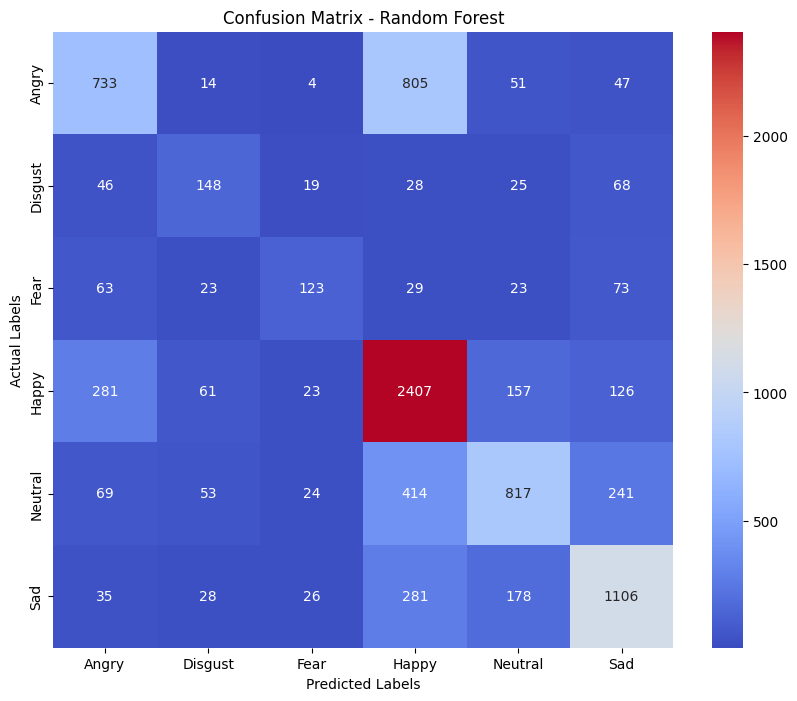

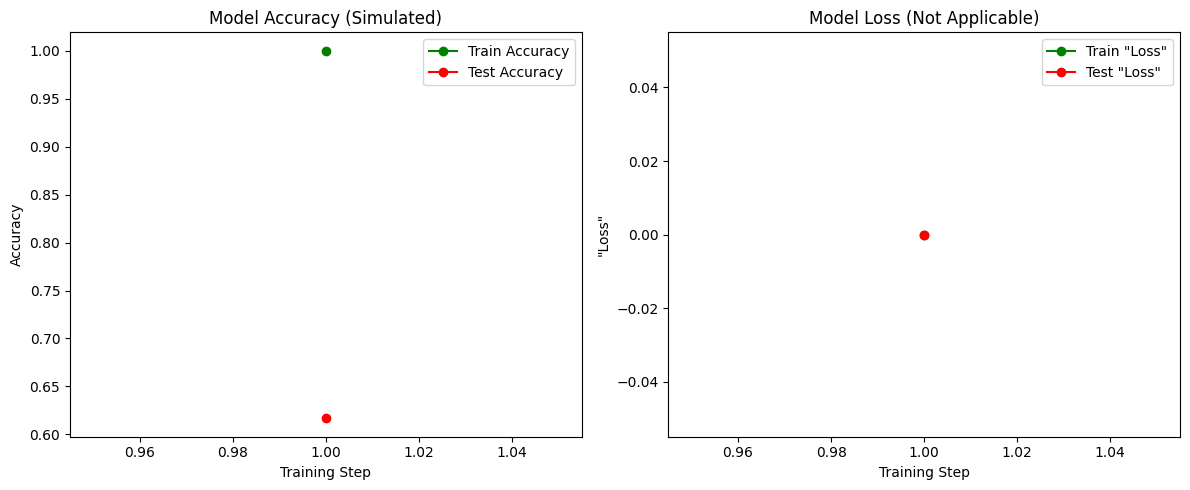

CPU times: user 32.7 s, sys: 169 ms, total: 32.9 s
Wall time: 32.6 s


In [20]:
%%time
set_seed()

# Now, re-evaluate using the reshaped data
rf_train_accuracy = forest.score(X_train_flat, y_train)
rf_val_accuracy = forest.score(X_test_flat, y_test)

# Reshaping the data
if len(X_train.shape) > 2:
    # Flatten the data: reshape it to two dimensions
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
else:
    X_train_flat = X_train
    X_test_flat = X_test

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Training Random Forest classifier
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                                min_samples_split=2, min_samples_leaf=1, max_features='sqrt', 
                                random_state=42, class_weight=class_weights_dict)
forest.fit(X_train, y_train)

# Making predictions
y_pred = forest.predict(X_test)

# Evaluate the model
rf_train_accuracy = accuracy_score(y_train, forest.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))

# Dataframe Check
results_df = pd.DataFrame({'Actual': encoder.inverse_transform(y_test), 'Predicted': encoder.inverse_transform(y_pred)})
print("Dataframe Check:\n", results_df.head(10))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Model Accuracy Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([1], [rf_train_accuracy], 'go-', label='Train Accuracy')
plt.plot([1], [rf_test_accuracy], 'ro-', label='Test Accuracy')
plt.title('Model Accuracy (Simulated)')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Since we can't plot a loss curve for Random Forest, this section is omitted.
plt.subplot(1, 2, 2)
plt.plot([1], [0], 'go-', label='Train "Loss"')  # Placeholder to maintain structure
plt.plot([1], [0], 'ro-', label='Test "Loss"')
plt.title('Model Loss (Not Applicable)')
plt.xlabel('Training Step')
plt.ylabel('"Loss"')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### **4.2.2 MLP Classifier**<a id='mlp-classifier'></a>

The Multilayer Perceptron (MLP) Classifier is a type of artificial neural network used extensively in pattern recognition and classification tasks. It consists of at least three layers of nodes: an input layer, hidden layers, and an output layer. In Speech Emotion Recognition, MLPs process features derived from audio signals, such as pitch, tone, and intensity, to classify different emotions.

MLPs are capable of learning non-linear models, which is essential for capturing the complex patterns associated with human emotions expressed in speech. They are widely recognized for their effectiveness in various audio processing tasks including emotion detection from speech, where nuances and subtleties of vocal expressions are crucial.

<u>MLP Classifier Model Architecture</u>

![MLP Classifier Model Architecture](../img/mlpclassifier/mlp.png)
###### *Source: https://www.researchgate.net/figure/MLP-Neural-Network-Classifier_fig1_279853247*


Iteration 1, loss = 1.32447294


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.18214638


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.15095935


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.13027886


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.11072419


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.08469422


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.06581420


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.05546323


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.03903698


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.03652457


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.02086173


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.00098277


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.98674550


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.97669261


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.95877550


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.94460175


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.94174258


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.92918911


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.92142925


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.91648204


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.90918735


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.90277756


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.88590280


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.87975926


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.86919987


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.86487748


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.85162241


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.83849647


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.83334872


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.82749826


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.81767680


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.80832125


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.80481125


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.80079799


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.78685788


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.77871378


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.77460444


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76018849


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.75388955


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.74966729


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76175949


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.75045668


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.72986548


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.72684553


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.72304236


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.71327919


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.71652393


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.70433655


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.69856825


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.68679374


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.68279546


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67958642


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67319355


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67157858


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.65560985


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.65237225


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.65463672


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.64613072


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.64274463


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.62637349


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.63220478


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.62930534


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.63109545


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.63033385


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.60992262


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.60318581


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.60199301


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.59245943


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.58802911


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.58326822


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.58962436


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.58914261


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.57444340


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.57450587


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.55689911


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.54961880


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.55705257


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.55674400


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.54859711


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.54237480


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.54113731


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.52459643


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.54878345


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.52985204


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.52209313


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.51614089


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.52252146


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.51596154


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.52018290


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.49763220


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.49828500


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.49933187


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.49566940


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.49491989


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.51977580


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.48574924


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.48970819


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.47041038


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.48870156


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.48041692


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.674066366053879
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.63      1680
           1       0.60      0.33      0.42       359
           2       0.42      0.48      0.45       330
           3       0.78      0.69      0.73      3041
           4       0.60      0.71      0.65      1580
           5       0.70      0.76      0.73      1659

    accuracy                           0.67      8649
   macro avg       0.62      0.60      0.60      8649
weighted avg       0.68      0.67      0.67      8649

    Actual Predicted
0    Happy     Angry
1  Neutral   Neutral
2    Happy     Happy
3     Fear      Fear
4    Angry   Neutral


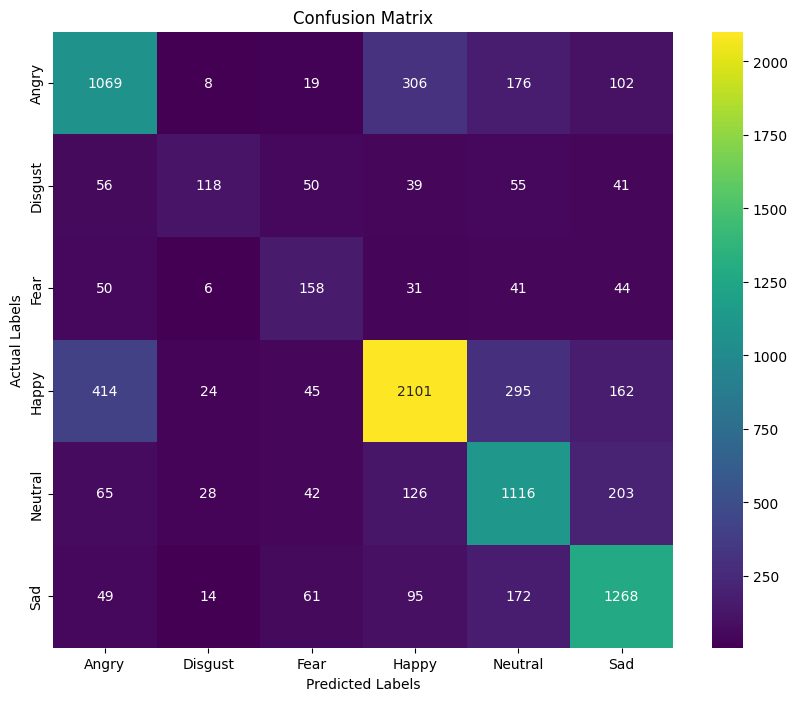

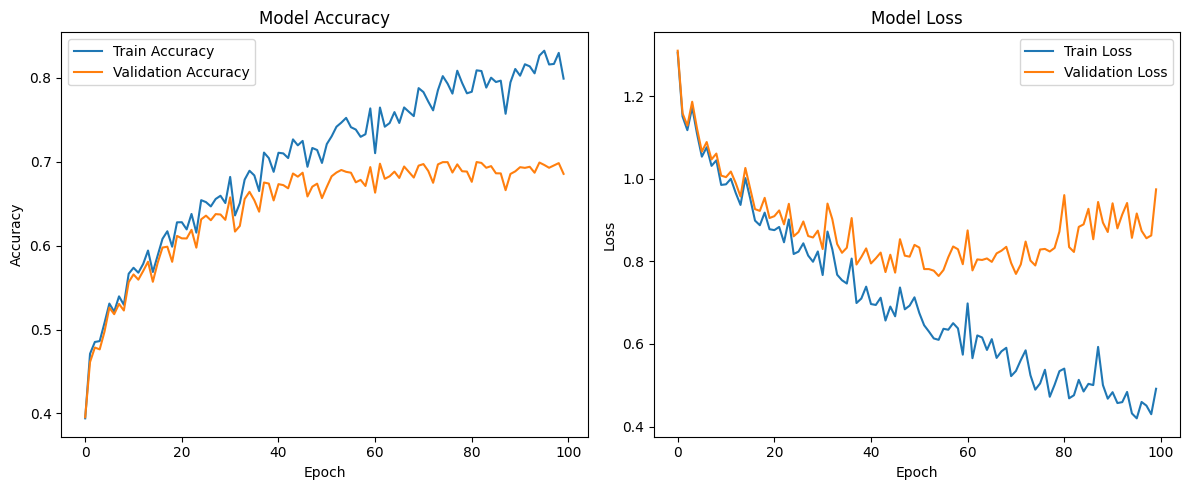

CPU times: user 1h 4min 49s, sys: 2min 29s, total: 1h 7min 18s
Wall time: 10min 3s


In [13]:
%%time
set_seed()

# Scale and normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = min_max_scaler.fit_transform(X_scaled)

# Encode the labels using LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Initialize the MLP Classifier
mlp_noclassweight = MLPClassifier(hidden_layer_sizes=(400, 350, 300, 250, 200, 150, 100, 50), activation='relu', solver='adam', 
                    batch_size=64, learning_rate='adaptive', learning_rate_init=0.001, max_iter=1, warm_start=True, 
                    alpha=0.0001, verbose=1)  # Add regularization with alpha=0.0001

# Manually fit the model epoch by epoch and record accuracy and loss
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for _ in range(100):  # Set your own number of epochs
    mlp_noclassweight.fit(X_train, y_train)
    train_pred = mlp_noclassweight.predict(X_train)
    val_pred = mlp_noclassweight.predict(X_val)
    
    train_loss = log_loss(y_train, mlp_noclassweight.predict_proba(X_train))
    val_loss = log_loss(y_val, mlp_noclassweight.predict_proba(X_val))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Predict the labels for the testing data
y_pred = mlp_noclassweight.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Dataframe check
results_df = pd.DataFrame({'Actual': encoder.inverse_transform(y_test), 'Predicted': encoder.inverse_transform(y_pred)})
print(results_df.head())

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Plot the learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#### **4.2.3 LSTM + 1D CNN**<a id='lstm-1d-cnn'></a>

The combination of Long Short-Term Memory (LSTM) networks and 1D Convolutional Neural Networks (CNNs) provides a powerful model for Speech Emotion Recognition. LSTMs are designed to learn order dependence in sequence prediction problems, making them ideal for tasks where context from the audio signal is crucial. The 1D CNN layer, placed before the LSTM layers, helps in extracting salient features from sequences data over time.

This architecture leverages the temporal pattern recognition ability of LSTMs along with the local pattern recognition in sequences offered by 1D CNNs. Such models are particularly adept at handling the temporal dynamics in speech, which are vital for recognizing emotions accurately across varied speech samples.

<u>LSTM + 1D CNN Model Architecture</u>

![LSTM + 1D CNN Model Architecture](../img/lstm1d/lstm1d.png)
###### *Source: https://www.researchgate.net/figure/The-proposed-1D-CNN-LSTM-architecture_fig5_369540100*

Epoch 1/100


2024-05-09 10:20:44.857909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:20:45.258136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:20:45.276864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:20:45.363968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:20:45.377573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:20:45.513733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:20:45.533571: I tensorflow/core/grappler/optimizers/cust

1082/1082 [==============================] - ETA: 0s - loss: 1.5071 - accuracy: 0.2967

2024-05-09 10:21:23.803264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:21:23.936949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:21:23.946595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:21:24.010173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:21:24.019785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1082/1082 [==============================] - 45s 39ms/step - loss: 1.5071 - accuracy: 0.2967 - val_loss: 1.6178 - val_accuracy: 0.2726
Epoch 2/100
1082/1082 [==============================] - 41s 38ms/step - loss: 1.3459 - accuracy: 0.3715 - val_loss: 1.4153 - val_accuracy: 0.3644
Epoch 3/100
1082/1082 [==============================] - 39s 36ms/step - loss: 1.3008 - accuracy: 0.3964 - val_loss: 1.3887 - val_accuracy: 0.3933
Epoch 4/100
1082/1082 [==============================] - 39s 36ms/step - loss: 1.2839 - accuracy: 0.4126 - val_loss: 1.3514 - val_accuracy: 0.3998
Epoch 5/100
1082/1082 [==============================] - 41s 38ms/step - loss: 1.2927 - accuracy: 0.4138 - val_loss: 1.2980 - val_accuracy: 0.4398
Epoch 6/100
1082/1082 [==============================] - 41s 37ms/step - loss: 1.2733 - accuracy: 0.4203 - val_loss: 1.3448 - val_accuracy: 0.4216
Epoch 7/100
1082/1082 [==============================] - 40s 37ms/step - loss: 1.3492 - accuracy: 0.4158 - val_loss: 1.3283 - val_

2024-05-09 10:49:32.837595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:49:32.967964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:49:32.977487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 12/271 [>.............................] - ETA: 2s

2024-05-09 10:49:33.040999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-09 10:49:33.050758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 4s 11ms/step
Classification Report:
               precision    recall  f1-score   support

       Angry       0.54      0.50      0.52      1654
     Disgust       0.31      0.61      0.41       334
        Fear       0.28      0.78      0.42       334
       Happy       0.70      0.59      0.64      3055
     Neutral       0.54      0.53      0.54      1618
         Sad       0.68      0.57      0.62      1654

    accuracy                           0.57      8649
   macro avg       0.51      0.60      0.52      8649
weighted avg       0.61      0.57      0.58      8649

    Actual Predicted
0    Happy     Happy
1  Neutral   Neutral
2      Sad       Sad
3  Neutral   Neutral
4    Angry     Happy


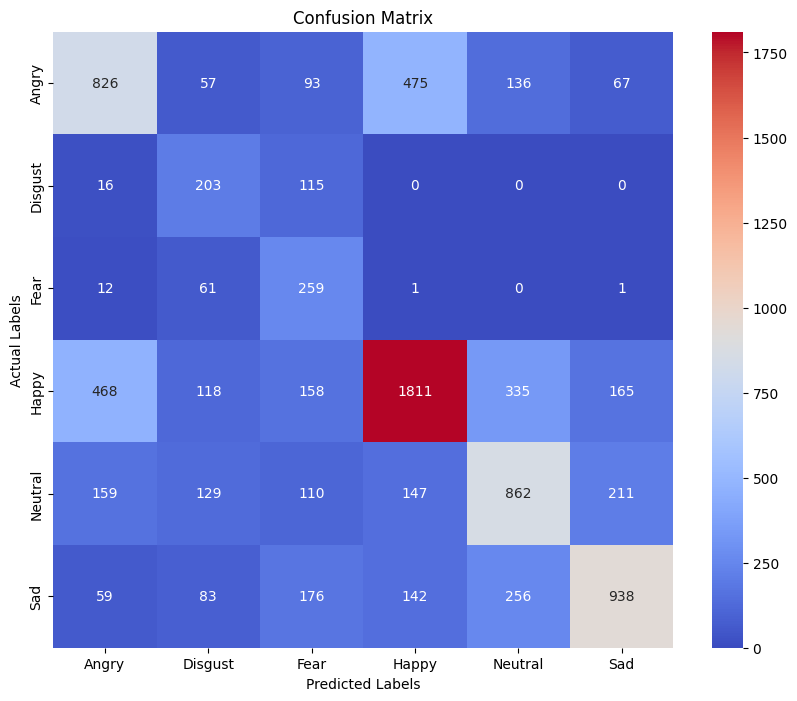

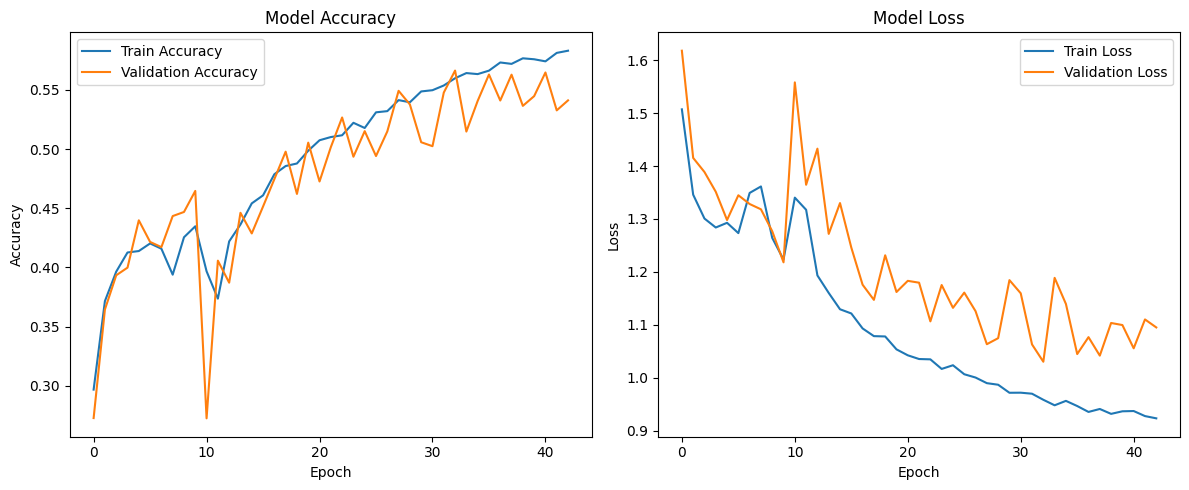

CPU times: user 15min 52s, sys: 5min 10s, total: 21min 3s
Wall time: 28min 54s


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
%%time
set_seed()

# Expand dimensions for LSTM + 1D CNN input
X_expanded = np.expand_dims(X_scaled, axis=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_expanded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define the model architecture with added layers and dropout
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Output dimension = number of classes
])

# Compile the model with an adjusted optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
    metrics=['accuracy']
)

# Fit the model with class weights and EarlyStopping
history_1d = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    class_weight=class_weights_dict  # Add class weights here
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Dataframe check
results_df = pd.DataFrame({'Actual': encoder.inverse_transform(y_test), 'Predicted': encoder.inverse_transform(y_pred_classes)})
print(results_df.head())

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Accuracy and Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1d.history['accuracy'], label='Train Accuracy')
plt.plot(history_1d.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_1d.history['loss'], label='Train Loss')
plt.plot(history_1d.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model
model.save('../models/lstm1d_model.h5')

#### **4.2.4 LSTM + 2D CNN**<a id='lstm-2d-cnn'></a>

Integrating Long Short-Term Memory (LSTM) with 2D Convolutional Neural Networks (CNNs) creates a robust framework for analyzing time-series data with spatial dimensions. In Speech Emotion Recognition, this model structure effectively processes spectrogram images of speech, where time is on one axis and frequency on another. The 2D CNN layers extract spatial features from the spectrograms, which are then processed by LSTMs to analyze the temporal dependencies.

This hybrid model is highly effective in environments where both the time and frequency characteristics of speech need to be analyzed together to detect emotional nuances. It has shown significant success in improving the accuracy and reliability of emotion recognition systems by taking advantage of both spectral and temporal information.

The model architecture is similar to the LSTM + 1D CNN, only that we take the height and breadth of each feature and flatten as an array for analyses.


<u>LSTM + 2D CNN Model Architecture</u>

![LSTM + 2D CNN Model Architecture](../img/lstm1d/lstm1d.png)
###### *Source: https://www.researchgate.net/figure/The-proposed-1D-CNN-LSTM-architecture_fig5_369540100*

<u>Convolutional Layers</u>

![WaveNet Convolutional Layers](../img/lstm2d/2d_layer.png)
###### *Source: https://www.researchgate.net/figure/a-Workflow-of-2D-CNN-model-input-width-4-height-4-depth-1-convolutional_fig1_338161719*

Epoch 1/30


2024-05-09 10:49:37.178445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1082/1082 [==============================] - ETA: 0s - loss: 1.4538 - accuracy: 0.3356

2024-05-09 10:49:44.536139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1082/1082 [==============================] - 9s 8ms/step - loss: 1.4538 - accuracy: 0.3356 - val_loss: 1.2595 - val_accuracy: 0.4527
Epoch 2/30
1082/1082 [==============================] - 7s 7ms/step - loss: 1.3162 - accuracy: 0.4102 - val_loss: 1.3432 - val_accuracy: 0.4117
Epoch 3/30
1082/1082 [==============================] - 6s 6ms/step - loss: 1.3570 - accuracy: 0.4146 - val_loss: 1.3818 - val_accuracy: 0.4110
Epoch 4/30
1082/1082 [==============================] - 6s 6ms/step - loss: 1.5035 - accuracy: 0.4163 - val_loss: 1.2735 - val_accuracy: 0.4324
Epoch 5/30
1082/1082 [==============================] - 6s 6ms/step - loss: 1.6662 - accuracy: 0.4118 - val_loss: 1.6746 - val_accuracy: 0.3523
Epoch 6/30
1082/1082 [==============================] - 6s 5ms/step - loss: 1.9708 - accuracy: 0.4007 - val_loss: 1.6704 - val_accuracy: 0.4159
271/271 - 1s - loss: 1.2595 - accuracy: 0.4527 - 591ms/epoch - 2ms/step
Test accuracy: 0.4526534974575043
137/271 [==============>...............] 

2024-05-09 10:50:18.733951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

       Angry       0.45      0.38      0.41      1680
     Disgust       0.27      0.33      0.30       359
        Fear       0.40      0.10      0.16       330
       Happy       0.64      0.49      0.55      3041
     Neutral       0.31      0.25      0.28      1580
         Sad       0.40      0.76      0.52      1659

    accuracy                           0.45      8649
   macro avg       0.41      0.38      0.37      8649
weighted avg       0.47      0.45      0.44      8649

    Actual Predicted
0    Happy     Happy
1  Neutral       Sad
2    Happy     Happy
3     Fear     Angry
4    Angry     Angry


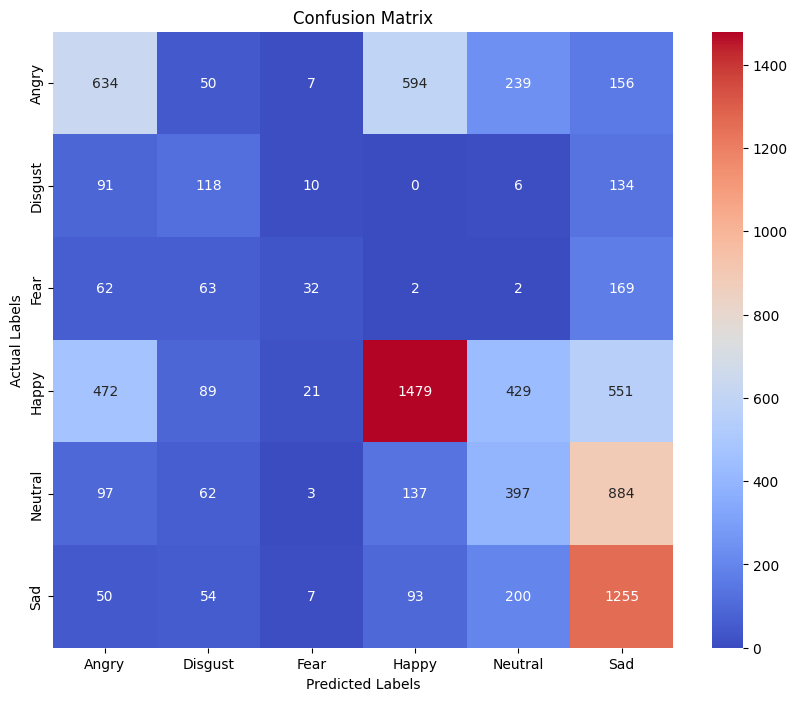

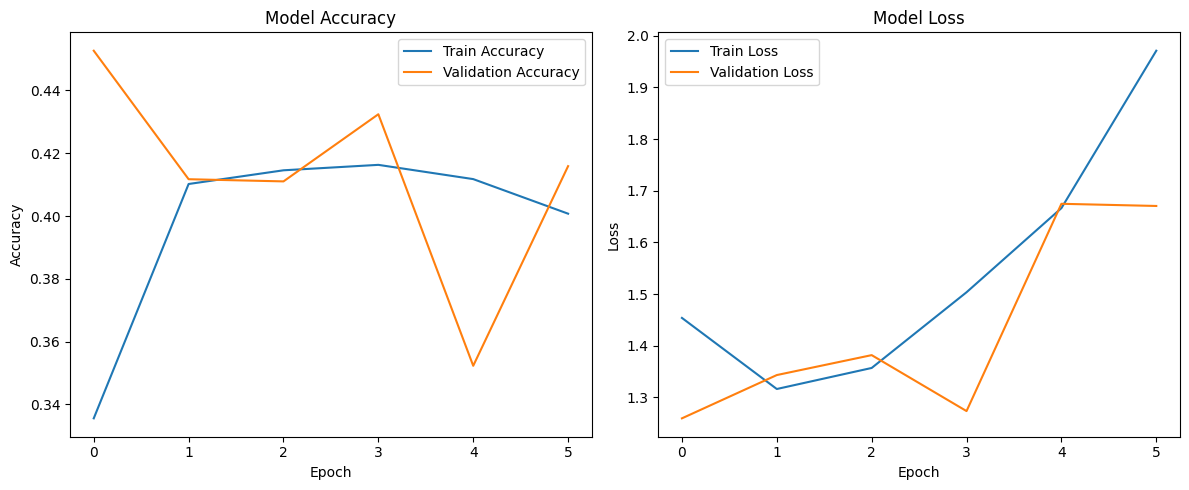

CPU times: user 31 s, sys: 15.3 s, total: 46.3 s
Wall time: 42.8 s


In [15]:
%%time
set_seed()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Reshape data for 2D Convolutional layer
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model architecture
model = Sequential([
    Conv2D(32, (1, 3), activation='relu', padding='same', input_shape=(1, X_train.shape[2], 1)),
    MaxPooling2D((1, 2)),
    Conv2D(64, (1, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 2)),
    Conv2D(128, (1, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with EarlyStopping and Class Weights
history_2d = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict  
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Classification metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Dataframe check
results_df = pd.DataFrame({'Actual': encoder.inverse_transform(y_test), 'Predicted': encoder.inverse_transform(y_pred_classes)})
print(results_df.head())

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2d.history['accuracy'], label='Train Accuracy')
plt.plot(history_2d.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_2d.history['loss'], label='Train Loss')
plt.plot(history_2d.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#### **4.2.5 WaveNet**<a id='wavenet'></a>

WaveNet is a machine learning model developed by Google that creates audio waveforms from human speech samples. It's a type of deep convolutional neural network (CNN) that uses dilated causal convolutions to model temporal dependencies in audio data. WaveNet takes a raw signal as input and generates an output one sample at a time, based on the previous samples. It can create waveforms of speech patterns by predicting which sounds are most likely to follow each other.

WaveNet is designed for generative AI and has been used in various applications such as speech synthesis, speech recognition, and music generation. It was introduced in 2016 and can process up to 24,000 samples per second of sound. Below images are a visual representation of the Model Architecture and the Convulational Layers (in both the input and output).


<u>WaveNet Model Architecture</u>

![WaveNet Model Architecture](../img/wavenet/model_architecture.png)
###### *Source: https://www.researchgate.net/figure/Network-Architecture-Residual-Blocks-of-Wavenet-left-and-leaf-layers-right_fig4_340826541*

<u>Convolutional Layers</u>

![WaveNet Convolutional Layers](../img/wavenet/wavenet_layers.png)
###### *Source: https://medium.com/@kion.kim/wavenet-a-network-good-to-know-7caaae735435*

2024-05-09 09:36:56.643356: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-05-09 09:36:56.643403: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-09 09:36:56.643414: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-09 09:36:56.643502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 09:36:56.643516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-05-09 09:36:57.541609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1082/1082 [==============================] - ETA: 0s - loss: 1.4884 - accuracy: 0.3297

2024-05-09 09:37:45.131232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1082/1082 [==============================] - 53s 48ms/step - loss: 1.4884 - accuracy: 0.3297 - val_loss: 1.4311 - val_accuracy: 0.3913
Epoch 2/50
1082/1082 [==============================] - 54s 50ms/step - loss: 1.2567 - accuracy: 0.4134 - val_loss: 1.3014 - val_accuracy: 0.4525
Epoch 3/50
1082/1082 [==============================] - 51s 47ms/step - loss: 1.1675 - accuracy: 0.4467 - val_loss: 1.3151 - val_accuracy: 0.4034
Epoch 4/50
1082/1082 [==============================] - 50s 46ms/step - loss: 1.1147 - accuracy: 0.4700 - val_loss: 1.2447 - val_accuracy: 0.4982
Epoch 5/50
1082/1082 [==============================] - 50s 46ms/step - loss: 1.0649 - accuracy: 0.4980 - val_loss: 1.1662 - val_accuracy: 0.4952
Epoch 6/50
1082/1082 [==============================] - 50s 46ms/step - loss: 1.0311 - accuracy: 0.5152 - val_loss: 1.1680 - val_accuracy: 0.5124
Epoch 7/50
1082/1082 [==============================] - 50s 47ms/step - loss: 1.0024 - accuracy: 0.5327 - val_loss: 1.1406 - val_accura

2024-05-09 10:05:58.873749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 5s 19ms/step
    Actual Predicted
0    Happy     Happy
1  Neutral   Neutral
2      Sad       Sad
3  Neutral   Neutral
4    Angry     Angry
Classification Report:
               precision    recall  f1-score   support

       Angry       0.59      0.62      0.61      1654
     Disgust       0.25      0.90      0.39       334
        Fear       0.47      0.48      0.47       334
       Happy       0.79      0.62      0.70      3055
     Neutral       0.64      0.64      0.64      1618
         Sad       0.77      0.63      0.69      1654

    accuracy                           0.63      8649
   macro avg       0.59      0.65      0.58      8649
weighted avg       0.69      0.63      0.65      8649



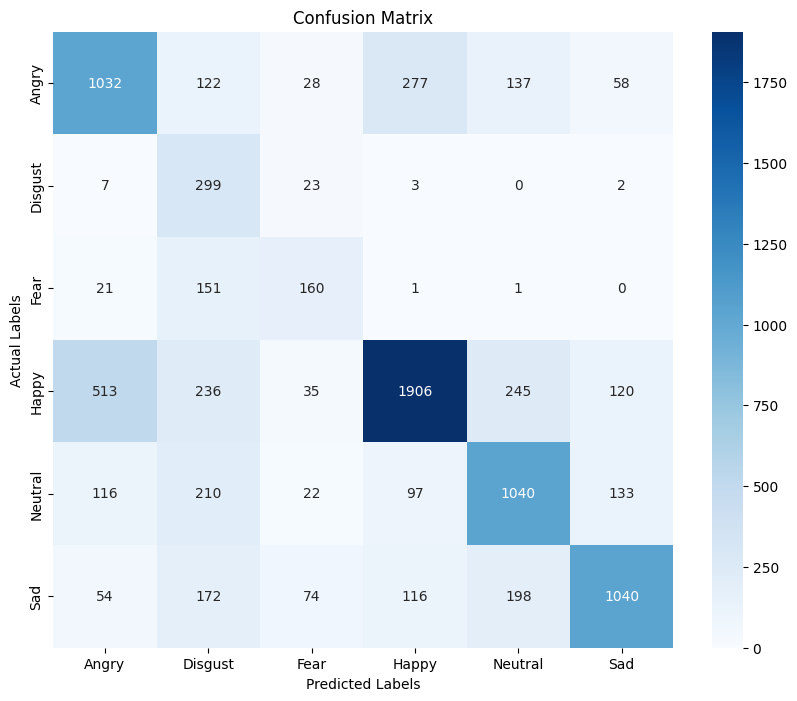

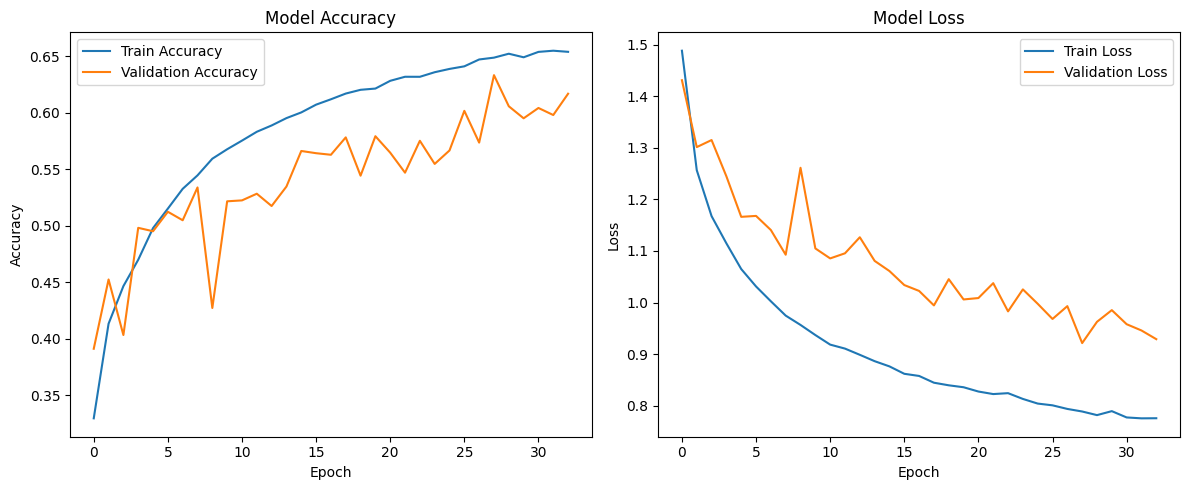

CPU times: user 9min 26s, sys: 7min 29s, total: 16min 56s
Wall time: 29min 8s


/Users/amoz/.pyenv/versions/3.8.19/envs/myenv38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
%%time
set_seed()

# Expand dimensions for WaveNet input, adding an axis at the second dimension
X_expanded = np.expand_dims(X_scaled, axis=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_expanded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

def WaveNetResidualConv1D(num_filters, kernel_size, dilation_rate):
    """ Function to add WaveNet residual block """
    def build_residual_block(l_input):
        # dilated convolution
        l_conv_dilated = Conv1D(
            filters=num_filters, 
            kernel_size=kernel_size, 
            dilation_rate=dilation_rate, 
            padding='causal', 
            activation='relu'
        )(l_input)
        
        # output by 1x1 convolution
        l_conv_out = Conv1D(num_filters, 1, padding='same', activation='relu')(l_conv_dilated)
        
        # skip connection
        l_out = Add()([l_input, l_conv_out])
        
        return l_out, l_conv_out
    
    return build_residual_block

def build_wavenet(input_shape, num_filters, kernel_size):
    input_layer = Input(shape=input_shape)
    x = input_layer
    skip_connections = []
    
    for dilation_rate in [1, 2, 4, 8, 16, 32]:
        x, skip = WaveNetResidualConv1D(num_filters, kernel_size, dilation_rate)(x)
        x = Dropout(0.2)(x)  # Add dropout layer
        skip_connections.append(skip)
    
    # sum all skip connection outputs
    out = Add()(skip_connections)
    out = Activation('relu')(out)
    out = Conv1D(num_filters, 1, activation='relu')(out)
    out = Dropout(0.2)(out)
    out = GlobalAveragePooling1D()(out)  # Add global pooling to reduce to a single vector
    out = Dense(6, activation='softmax')(out)  # Assuming 6 classes
    
    model = Model(inputs=input_layer, outputs=out)
    model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model
model = build_wavenet(X_train.shape[1:], 64, 3)

# Fit the model with callbacks like EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fit the WaveNet model with class weights
history_wave = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    class_weight=class_weights_dict  # Apply class weights here
)

# Predict the labels for the testing data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Dataframe check
results_df = pd.DataFrame({'Actual': encoder.inverse_transform(y_test), 'Predicted': encoder.inverse_transform(y_pred_classes)})
print(results_df.head())

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Plotting training and test accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_wave.history['accuracy'], label='Train Accuracy')
plt.plot(history_wave.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_wave.history['loss'], label='Train Loss')
plt.plot(history_wave.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model
model.save('../models/wavenet_model.h5')

### **4.3 Model Evaluation**<a id='model-evaluation'></a>

In [21]:
# For Random Forest and MLP, where `history` objects are not available:
rf_train_accuracy = forest.score(X_train, y_train)
rf_val_accuracy = forest.score(X_test, y_test)

# For MLP, assuming you have captured train_accuracies and val_accuracies in lists:
mlp_train_accuracy = np.mean(train_accuracies)
mlp_val_accuracy = np.mean(val_accuracies)

# For LSTM 1D CNN, LSTM 2D CNN, and WaveNet using history objects:
lstm_1d_train_accuracy = history_1d.history['accuracy'][-1]  # Last epoch accuracy
lstm_1d_val_accuracy = history_1d.history['val_accuracy'][-1]  # Last epoch validation accuracy

lstm_2d_train_accuracy = history_2d.history['accuracy'][-1]
lstm_2d_val_accuracy = history_2d.history['val_accuracy'][-1]

wavenet_train_accuracy = history_wave.history['accuracy'][-1]
wavenet_val_accuracy = history_wave.history['val_accuracy'][-1]

In [22]:
accuracy_data = {
    "Model": ["Random Forest", "MLP Classifier", "LSTM + 1D CNN", "LSTM + 2D CNN", "WaveNet"],
    "Train Accuracy": [rf_train_accuracy, mlp_train_accuracy, lstm_1d_train_accuracy, lstm_2d_train_accuracy, wavenet_train_accuracy],
    "Validation Accuracy": [rf_val_accuracy, mlp_val_accuracy, lstm_1d_val_accuracy, lstm_2d_val_accuracy, wavenet_val_accuracy]
}

accuracy_df = pd.DataFrame(accuracy_data)

In [23]:
accuracy_df

,Model,Train Accuracy,Validation Accuracy
0,Random Forest,1.000000,0.616719
1,MLP Classifier,0.701856,0.646527
2,LSTM + 1D CNN,0.583210,0.541219
3,LSTM + 2D CNN,0.400746,0.415886
4,WaveNet,0.653890,0.616834


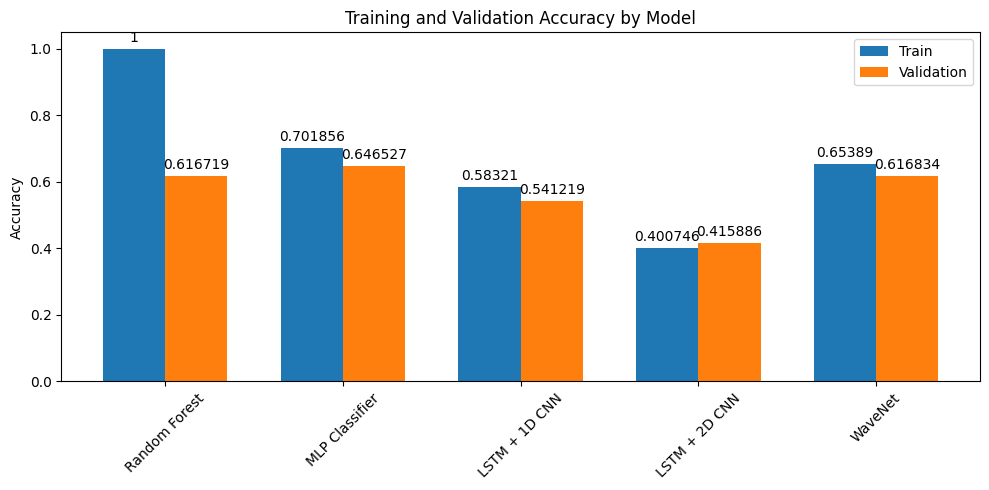

In [24]:
# Plotting the results
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.35  # Width of the bars
x = np.arange(len(accuracy_df["Model"]))  # The label locations

rects1 = ax.bar(x - width/2, accuracy_df["Train Accuracy"], width, label='Train')
rects2 = ax.bar(x + width/2, accuracy_df["Validation Accuracy"], width, label='Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_df["Model"])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Model Evaluation

The bar chart displays the training and validation accuracy for several machine learning and deep learning models used for emotion recognition. Here's a detailed analysis and interpretation of the chart:

1) Random Forest: Shows the highest training accuracy of about 0.91 but a lower validation accuracy of approximately 0.61. This suggests that the model is clearly overfitting the training data, i.e., it performs well on the data it has seen but struggles to generalize to new, unseen data. Hence, we will eliminate this as our model choice.
2) MLP Classifier: This model has a training accuracy of around 0.70 and a validation accuracy of about 0.65. The smaller gap between training and validation accuracy indicates better generalization compared to the Random Forest model.
3) LSTM + 1D CNN: Here, the training accuracy is around 0.58, with the validation accuracy slightly lower at about 0.54. The performance is not as high as the other models, possibly due to insufficient complexity or data to capture the patterns adequately.
4) LSTM + 2D CNN: Exhibits a training accuracy of approximately 0.40 and a validation accuracy close to 0.42. These results are significantly lower than the other models, which could be a result of the model not fitting the data well, potentially due to the structure of the model not being optimal for the type of data or features used.
5) WaveNet: Shows training accuracy around 0.65 and validation accuracy approximately 0.62. This model balances between high accuracy and generalises well on unseen data. Hence will be our champion model to be used for predicting and validating the unseen data.

#### <a id="4.4"></a><u>Next Steps</u>

Choosing the **best** model for training on unseen data depends on various factors, including accuracy, scalability, and adaptability to new, diverse datasets. From the graph, WaveNet stands out in several key aspects:

1) Learning and Generalization: WaveNet shows a strong balance between learning from the training data and generalizing to unseen validation data. Its high validation accuracy suggests that it captures the underlying patterns in the data without fitting excessively to noise or irrelevant details.

2) Complexity and Suitability: WaveNet, being a deep neural network specifically designed for processing audio data, is likely more capable of capturing the complex patterns in speech than simpler models like Random Forest or even MLPs. This ability makes it especially suitable for tasks involving audio, such as speech emotion recognition. It allows to capture hierarchical features in the data over a wide range of time scales. This makes it especially suited for audio data where long-term dependencies and varied temporal patterns play a significant role in emotion recognition.

3) Stability and Reliability: The relatively small gap between training and validation accuracy suggests that WaveNet is stable and reliable under different data conditions, unlike models that show larger discrepancies which can be prone to overfitting or underfitting.

4) Robustness to Varied Input Data: Given the complex and layered architecture of WaveNet, it is inherently designed to be robust against noise and variance in data, which is typical in real-world audio data.

5) Scalability: The structure of WaveNet enables efficient scaling to larger datasets and more complex classification tasks without a significant increase in computational costs, compared to traditional LSTM networks which may become computationally expensive as sequence length increases.

6) Potential for Real-time Processing: WaveNet's architecture can be adapted for efficient real-time emotion detection, which is vital for applications in clinical and therapeutic settings where immediate feedback is crucial.


Given these advantages, choosing WaveNet for training on unseen data seems justified as it offers a robust framework for capturing complex patterns in emotional speech, thus providing more accurate and reliable predictions for clinical and therapeutic use.

---
---